<a href="https://colab.research.google.com/github/ldaniel-hm/eml_tabular/blob/main/MonteCarloTodasLasVisitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Monte Carlo con Políticas epsilon-soft**

_Esto es un ejemplo de uso de Gymnasium e informe sobre un experimento de aprendizaje por refuerzo_

````
Luis D. Hernández.
<ldaniel at um.es>
````

Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo con políticas epsilon-soft. El propósito de este análisis es entrenar un agente en un entorno de gym con el juego "FrozenLake", un entorno estándar en el que el agente debe aprender a moverse a través de un mapa en busca de una meta, evitando caer en agujeros. A continuación, se presenta una descripción de las diferentes partes del código y el proceso utilizado en el experimento.

🎯 **Ojo, el código debe modificarse para ser un auténtico Monte Carlo. Supongo que sabrás darte cuenta.**

## **1. Preparación del Entorno**

La preparación consta de las siguientes partes:
- **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno `gymnasium` para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
- **Importación de Librerías**: Se importan las bibliotecas necesarias como `numpy` para el manejo de matrices y `matplotlib` para la visualización de los resultados.

- **Importación del Entorno "FrozenLake"**:
Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje.

#### 3. **Funciones para Mostrar los Resultados**
   - Se define una función para graficar la proporción de recompensas obtenidas en cada episodio del entrenamiento. Esto ayuda a visualizar el progreso del agente en términos de su desempeño durante el entrenamiento.



##### **Código de la Instalación e Importación**
----

In [1]:
%%capture
#@title Instalamos gym
! pip install 'gym[box2d]==0.20.0'
! pip install numpy
! pip install matplotlib
! pip install tqdm
! pip install gymnasium 
! pip install "gymnasium[toy-text]

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
# ! apt install swig
! pip install gymnasium[box2d]

In [1]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym

In [2]:
#@title Importamos el lago helado
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.

## **2. Diseño del Agente**

El diseño del agente consta de dos partes, el algoritmo con el que aprende y las políticas (toma de decisiones) que realiza.

- **Políticas del Agente**
   - **Política epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
   - **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
   - **Política greedy**: Es la usada una vez que "ha aprendido".

- **Algoritmo de Iteración de Valor**
  - Se implementa el algoritmo de iteración de valor utilizando Monte Carlo.
  - Se usa una versión "on-policy" de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft.
  - Se basa en el criterio de todas las visitas.
  - Otro aspecto es que la actualización de los retornos no se realiza en el orden inverso a las visitas.

#### **Código de las políticas y algoritmo MC**
----------------

In [4]:
# @title Políticas del agente

# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# Política epsilon-soft. Se usa para el entrenamiento
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    pi_A[best_action] += (1.0 - epsilon)
    return pi_A

# Política epsilon-greedy a partir de una epsilon-soft
def epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = random_epsilon_greedy_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=pi_A)

# Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

**Correcciones al Algoritmo Monte Carlo**

| **Problema Identificado** | **Cambio Realizado** |
|---------------------------|----------------------|
| **Uso incorrecto del retorno para cada visita**  | En el código original, se calculaba un único `result_sum` acumulado para todo el episodio y se usaba este mismo valor en todas las actualizaciones de `Q(s, a)`, lo que generaba errores en la estimación. En un método Monte Carlo correcto, cada estado-acción debe actualizarse con el retorno acumulado *desde el momento en que fue visitado* hasta el final del episodio. | Se modificó la estructura de `episode` para almacenar no solo `(estado, acción)`, sino también la `recompensa` obtenida en cada paso. Esto permite calcular correctamente los retornos acumulados desde cada visita dentro del episodio. |
| **Falta de cálculo de retornos en orden inverso** | Normalmente, el método Monte Carlo recorre los episodios en orden inverso, acumulando recompensas y propagándolas correctamente. Sin embargo, en la implementación original, `Q` se actualizaba en el orden de aparición del estado-acción, sin ajustar correctamente los retornos acumulados. Esto causaba una asignación incorrecta del valor de `Q`. | Se implementó un recorrido inverso del episodio para calcular correctamente los retornos `G`. Ahora, los valores se acumulan desde el final del episodio hacia el principio, asegurando que cada estado-acción reciba el retorno correspondiente desde su posición hasta el final. |
| **Actualización Every-Visit con retornos incorrectos** | Se estaba aplicando el criterio de *todas las visitas* (*Every-Visit*), pero debido a la incorrecta asignación de retornos, todas las visitas de un mismo estado-acción dentro de un episodio recibían el mismo valor de actualización, lo que podía sesgar los valores de `Q`. Esto podía llevar a una convergencia ineficiente o errónea. | Ahora, cada estado-acción se actualiza con el retorno acumulado correcto en cada visita. Se mantiene la política *Every-Visit*, pero asegurando que cada visita contribuya correctamente a la estimación de `Q(s, a)`. Además, se usa un esquema de promediado incremental para mejorar la estabilidad del aprendizaje. |
| **Falta de exploración controlada** | Sin una adecuada política de exploración, el agente puede quedarse atrapado en soluciones subóptimas, sin descubrir mejores estrategias. | Se mantiene la política *epsilon-greedy* para garantizar suficiente exploración durante el aprendizaje. Además, se implementó un *decay* opcional de `epsilon` para reducir progresivamente la exploración conforme el agente mejora su desempeño (*GLIE: Greedy in the Limit with Infinite Exploration*). |


In [5]:
def on_policy_all_visit(env, num_episodes=5000, epsilon=0.4, decay=False, discount_factor=1.0):
    nA = env.action_space.n
    Q = np.zeros([env.observation_space.n, nA])
    n_visits = np.zeros([env.observation_space.n, nA])
    stats = 0.0
    list_stats = [stats]
    step_display = num_episodes / 10

    for t in range(num_episodes):
        state, info = env.reset(seed=100)
        done = False
        episode = []  # almacenará tuplas (estado, acción, recompensa)
        while not done:
            if decay:
                # Reducir epsilon de forma gradual (GLIE)
                epsilon = min(1.0, 1000.0 / (t + 1))
            action = epsilon_greedy_policy(Q, epsilon, state, nA)
            new_state, reward, terminated, truncated, info = env.step(action)
            # Guardamos la transición (estado, acción, recompensa) del paso actual
            episode.append((state, action, reward))
            # Avanzar al siguiente estado
            state = new_state
            done = terminated or truncated

        # Episodio completo: calcular retornos acumulados y actualizar Q
        G = 0.0
        # Recorremos la lista de transiciones al revés
        for state, action, reward in reversed(episode):
            # Actualizamos el retorno acumulado: G = r_{t+1} + γ * G
            G = reward + discount_factor * G
            # Actualización Every-Visit: no filtramos visitas repetidas del mismo episodio
            n_visits[state, action] += 1.0
            alpha = 1.0 / n_visits[state, action]  # factor de promedio incremental
            # Actualizar valor Q hacia el retorno G obtenido desde este estado-acción
            Q[state, action] += alpha * (G - Q[state, action])

        # Actualizar estadísticas (proporción acumulada de recompensa)
        # Al terminar el bucle inverso, G contiene el retorno desde el estado inicial
        stats += G  
        list_stats.append(stats / (t + 1))
        if t % step_display == 0 and t != 0:
            print(f"Episodio {t}, éxito promedio: {stats/t:.2f}, epsilon: {epsilon:.2f}")

    return Q, list_stats


## **3. Experimentación**

   - En esta sección, el algoritmo de Monte Carlo con la política epsilon-soft se ejecuta tanto para el entorno de 4x4 como al de 8x8 de FrozenLake sin resbalar.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (5000 en concreto)

   - Además en el escenario 8x8 el  epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporcion de recompensas obtendias.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

### **3.1 Repressentaciones Gráficas**

Para comprobar el aprendizaje se mostrará la función $f(t)=\frac{\sum_{i=1}^t R_i}{t}$ para $t=1,2,\ldots, NumeroEpisodios$. La justificación es la siguiente. Como sabemmos que el retorno en el estados inicial 1 (pues no hay descuento) o 9, si se divide por el número de episodios ejecutados se calcular el porcentaje de recompensas positivas obtenidas. Dicho de otra forma, nos dirá el porcentaje de veces que el agente ha llegado al estado terminal.

*TODO:* Contruir una gráfica que muestre la longitud de los episodios en cada estado junto con la curva de tendencia.

In [2]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Define la función para mostrar el tamaño de los episodios
def plot_episode_lengths(episode_lengths, window=50):
    indices = list(range(len(episode_lengths)))

    plt.figure(figsize=(6, 3))
    plt.plot(indices, episode_lengths, label="Longitud de episodio", alpha=0.6)

    # Calcular y graficar la curva de tendencia con una media móvil
    if len(episode_lengths) >= window:
        moving_avg = np.convolve(episode_lengths, np.ones(window) / window, mode="valid")
        plt.plot(range(window - 1, len(episode_lengths)), moving_avg, label="Tendencia (Media Móvil)", color='red')

    plt.title('Longitud de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Longitud')
    plt.grid(True)
    plt.legend()
    plt.show()

### **3.2 Experimentación en el escenario 4x4**



   - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ constante




In [7]:
# @title Aprendizaje
Q, list_stats = on_policy_all_visit(env4, num_episodes=50000, epsilon=0.4, discount_factor=1)

Episodio 5000, éxito promedio: 0.54, epsilon: 0.40
Episodio 10000, éxito promedio: 0.54, epsilon: 0.40
Episodio 15000, éxito promedio: 0.54, epsilon: 0.40
Episodio 20000, éxito promedio: 0.53, epsilon: 0.40
Episodio 25000, éxito promedio: 0.53, epsilon: 0.40
Episodio 30000, éxito promedio: 0.53, epsilon: 0.40
Episodio 35000, éxito promedio: 0.53, epsilon: 0.40
Episodio 40000, éxito promedio: 0.53, epsilon: 0.40
Episodio 45000, éxito promedio: 0.53, epsilon: 0.40


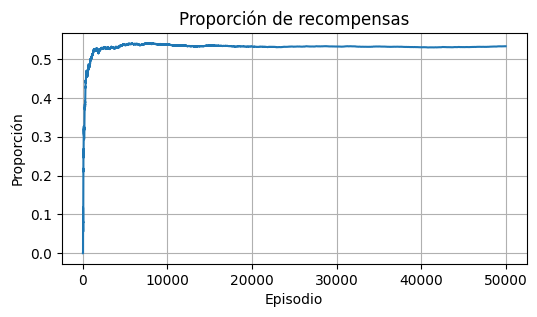

Máxima proporcion: 0.53354


In [8]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [9]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", Q)


Valores Q para cada estado:
 [[0.49971945 0.54257679 0.46537803 0.5299405 ]
 [0.52586335 0.         0.51054384 0.44920319]
 [0.43128964 0.6036036  0.45669291 0.50943396]
 [0.53703704 0.         0.47368421 0.33333333]
 [0.53936122 0.62162901 0.         0.53290623]
 [0.         0.         0.         0.        ]
 [0.         0.8056872  0.         0.54109589]
 [0.         0.         0.         0.        ]
 [0.62449623 0.         0.72225653 0.54768154]
 [0.62439132 0.8269934  0.7987013  0.        ]
 [0.71136131 0.95575357 0.         0.61363636]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.82302012 0.95990659 0.71933729]
 [0.82746019 0.95965643 1.         0.80630865]
 [0.         0.         0.         0.        ]]


- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [10]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 1, 2, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




### **3.3 Experimentación en el escenario 8x8**

  - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ decreciente



In [11]:
# @title Aprendizaje
Q, list_stats = on_policy_all_visit(env8, num_episodes=50000, epsilon=0.4, decay=True, discount_factor=1)

Episodio 5000, éxito promedio: 0.49, epsilon: 0.20
Episodio 10000, éxito promedio: 0.68, epsilon: 0.10
Episodio 15000, éxito promedio: 0.76, epsilon: 0.07
Episodio 20000, éxito promedio: 0.79, epsilon: 0.05
Episodio 25000, éxito promedio: 0.82, epsilon: 0.04
Episodio 30000, éxito promedio: 0.85, epsilon: 0.03
Episodio 35000, éxito promedio: 0.87, epsilon: 0.03
Episodio 40000, éxito promedio: 0.88, epsilon: 0.02
Episodio 45000, éxito promedio: 0.89, epsilon: 0.02


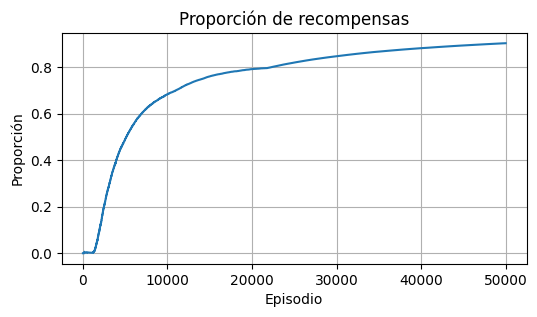

Máxima proporcion: 0.9021


In [12]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [13]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", Q)

Valores Q para cada estado:
 [[0.74196806 0.73901187 0.91199325 0.63719315]
 [0.30760626 0.32026144 0.9248844  0.30282039]
 [0.45187602 0.48642659 0.92684702 0.48166127]
 [0.60036058 0.55153374 0.92501645 0.60118694]
 [0.73987874 0.77658976 0.95530402 0.79468783]
 [0.68882175 0.6982823  0.944072   0.70914543]
 [0.71830986 0.94663515 0.73344371 0.73073593]
 [0.34375    0.79795158 0.40136054 0.34265734]
 [0.22586999 0.22700199 0.78438045 0.19588313]
 [0.29334365 0.26264881 0.80444817 0.28593272]
 [0.34659686 0.21975806 0.35418769 0.83529008]
 [0.19392523 0.         0.67064677 0.18615752]
 [0.4197731  0.3729097  0.81031455 0.50162338]
 [0.55054432 0.46128501 0.576      0.8263925 ]
 [0.70603229 0.76329331 0.94871265 0.72860847]
 [0.74870912 0.94837398 0.72615385 0.75488599]
 [0.05464481 0.04696133 0.34863813 0.04644809]
 [0.08474576 0.07321429 0.06354515 0.48184615]
 [0.22371365 0.39876703 0.         0.21489362]
 [0.         0.         0.         0.        ]
 [0.         0.04545455 0.52338

- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

In [14]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2,

## **4. Análisis y Estudios Futuros**

### **4.1 Análisis de Resultados**

- En los dos entornos (4x4 y 8x8), el agente comienza con un conocimiento muy limitado, pero gradualmente mejora su desempeño a medida que avanza en los episodios. Este comportamiento se puede observar en el gráfico de la proporción de recompensas, que aumenta con el tiempo.
- En el entorno 4x4, la máxima proporción de éxito alcanzada fue 0.522, mientras que en el entorno 8x8, la máxima alcanzada fue 0.914. Esto refleja que el agente aprendió a optimizar su estrategia en un entorno más complejo.
- La política óptima obtenida muestra las acciones recomendadas por el agente en cada estado del entorno. En el entorno 8x8, la política es más compleja debido a la mayor cantidad de estados y la dificultad del entorno.

### **4.2 Propuestas para Estudios Futuros**

1. **Evaluar con Otros Entornos**: Sería interesante aplicar este algoritmo a otros entornos más complejos de `gym`, como "Taxi-v3" o "MountainCar", para analizar cómo se comporta el agente en situaciones con dinámicas más complicadas.
   
2. **Optimización del Decaimiento de Epsilon**: Aunque se utilizó un decaimiento de epsilon en el segundo experimento, se podría investigar la efectividad de diferentes tasas de decaimiento o incluso explorar algoritmos como `Q-learning` para comparar su desempeño. Graficamente se trataría de mostrar la curva de la tasa de aciertos para distintas funciones de decaimientos

3. **Análisis del Impacto de los descuentos en las Recompensas**: El estudio se ha hecho para $\gamma = 1$; pero no se ha probado qué pasa cuando  $0 \leq \gamma < 1$. Se trataría de estudiar la curva para distintos valores de $\gamma$

4. **Nuevas gráficas**: Aquí solo se ha usado la proporción de aciertos, pero sería interesante qué relación entre dicha tasa y las tamaños de los episodios.

4. **Ampliación del Algoritmo**: Explorar otros enfoques de Monte Carlo o incluso combinar Monte Carlo con otros algoritmos de aprendizaje por refuerzo, como el Deep Q-Network (DQN), podría mejorar aún más los resultados en entornos más complejos.


Testeos

**Montecarlo on policy**    
El término on-policy se refiere a un enfoque en el que el agente aprende y actualiza su política basándose únicamente en las acciones que toma de acuerdo con la política que está aprendiendo. Es decir, el agente utiliza la política que está aprendiendo para seleccionar las acciones durante el proceso de exploración y la actualización de los valores de esa política.


Problema de Froze Lake de 4x4 con recompensas:  
- 1 si llega.
- 0 si no llega.

In [3]:
import gymnasium as gym
from src_agents import MonteCarloOnPolicy, MonteCarloOffPolicy, SARSA, QLearning

Entrenando:  19%|███████▋                                | 968/5000 [00:00<00:01, 3212.45episodio/s]

Episodio 500, éxito promedio: 0.01, epsilon: 1.00
Episodio 1000, éxito promedio: 0.01, epsilon: 1.00


Entrenando:  38%|██████████████▊                        | 1893/5000 [00:00<00:01, 2872.35episodio/s]

Episodio 1500, éxito promedio: 0.04, epsilon: 0.67
Episodio 2000, éxito promedio: 0.11, epsilon: 0.50


Entrenando:  54%|█████████████████████▏                 | 2718/5000 [00:00<00:00, 2547.46episodio/s]

Episodio 2500, éxito promedio: 0.18, epsilon: 0.40


Entrenando:  64%|█████████████████████████              | 3220/5000 [00:01<00:00, 2248.31episodio/s]

Episodio 3000, éxito promedio: 0.25, epsilon: 0.33


Entrenando:  73%|████████████████████████████▌          | 3667/5000 [00:01<00:00, 2109.37episodio/s]

Episodio 3500, éxito promedio: 0.32, epsilon: 0.29


Entrenando:  86%|█████████████████████████████████▍     | 4289/5000 [00:01<00:00, 1944.10episodio/s]

Episodio 4000, éxito promedio: 0.37, epsilon: 0.25


Entrenando:  97%|█████████████████████████████████████▊ | 4854/5000 [00:02<00:00, 1813.53episodio/s]

Episodio 4500, éxito promedio: 0.41, epsilon: 0.22


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:02<00:00, 2271.71episodio/s]

Valor Q final con MonteCarloOnPolicy:
[[0.37984252 0.39719321 0.39233406 0.61769584]
 [0.19405321 0.         0.53862847 0.18404908]
 [0.2566586  0.62921914 0.27802691 0.34939759]
 [0.41059603 0.         0.10596026 0.09248555]
 [0.18897638 0.5457442  0.         0.1829653 ]
 [0.         0.         0.         0.        ]
 [0.         0.81681877 0.         0.4789916 ]
 [0.         0.         0.         0.        ]
 [0.32937685 0.         0.70818505 0.27222222]
 [0.43457944 0.82965517 0.58974359 0.        ]
 [0.61434978 0.94409504 0.         0.52444444]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.64942529 0.95545977 0.57541899]
 [0.7641196  0.92333333 1.         0.75174825]
 [0.         0.         0.         0.        ]]


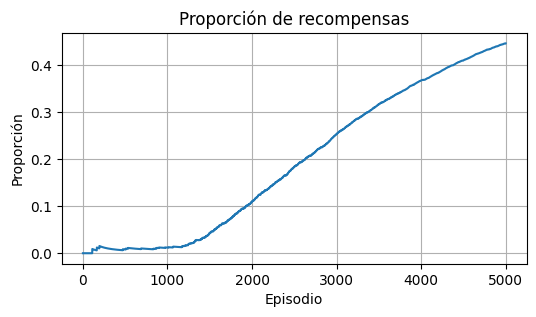

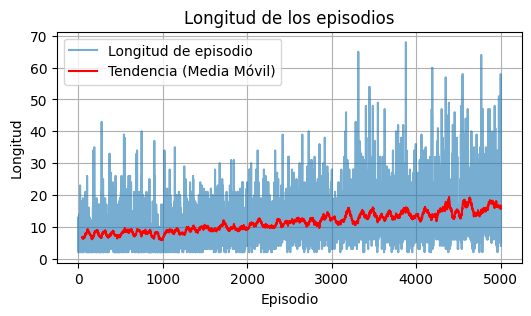

In [4]:
import numpy as np
import gymnasium as gym
import random
from src_agents import MonteCarloOnPolicy
import matplotlib.pyplot as plt

# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Establecer semilla en el entorno con el método reset
env.reset(seed=seed_value)

# Crear y entrenar el agente
agente = MonteCarloOnPolicy(env, decay=True)
Q, stats, episode_lengths = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final con MonteCarloOnPolicy:")
print(Q)

# Graficar las estadísticas y las longitudes de los episodios
plot(stats)
plot_episode_lengths(episode_lengths)


Entrenando:  19%|███████▋                                | 956/5000 [00:00<00:01, 3129.03episodio/s]

Episodio 500, éxito promedio: 0.01, epsilon: 1.00
Episodio 1000, éxito promedio: 0.01, epsilon: 1.00


Entrenando:  37%|██████████████▍                        | 1847/5000 [00:00<00:01, 2346.79episodio/s]

Episodio 1500, éxito promedio: 0.01, epsilon: 0.67


Entrenando:  42%|████████████████▎                      | 2091/5000 [00:00<00:01, 2079.76episodio/s]

Episodio 2000, éxito promedio: 0.01, epsilon: 0.50


Entrenando:  53%|████████████████████▊                  | 2671/5000 [00:01<00:01, 1534.68episodio/s]

Episodio 2500, éxito promedio: 0.01, epsilon: 0.40


Entrenando:  62%|████████████████████████▏              | 3103/5000 [00:01<00:01, 1171.77episodio/s]

Episodio 3000, éxito promedio: 0.01, epsilon: 0.33


Entrenando:  71%|████████████████████████████▍           | 3556/5000 [00:02<00:01, 975.41episodio/s]

Episodio 3500, éxito promedio: 0.01, epsilon: 0.29


Entrenando:  82%|████████████████████████████████▋       | 4092/5000 [00:02<00:01, 805.05episodio/s]

Episodio 4000, éxito promedio: 0.01, epsilon: 0.25


Entrenando:  91%|████████████████████████████████████▍   | 4556/5000 [00:03<00:00, 679.72episodio/s]

Episodio 4500, éxito promedio: 0.01, epsilon: 0.22


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:04<00:00, 1194.66episodio/s]

Valor Q final con MonteCarloOffPolicy:
[[ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00 -3.2192e+04  0.0000e+00]
 [ 2.5600e+02  1.6000e+01  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  4.0000e+00  1.0000e+00  0.0000e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]]


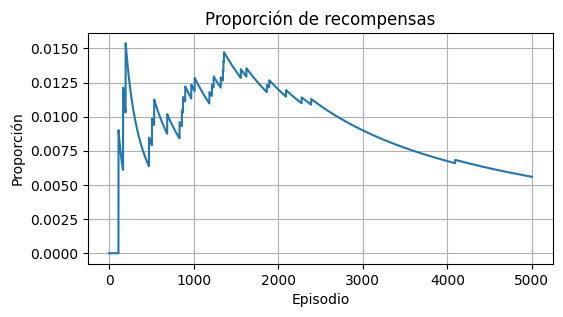

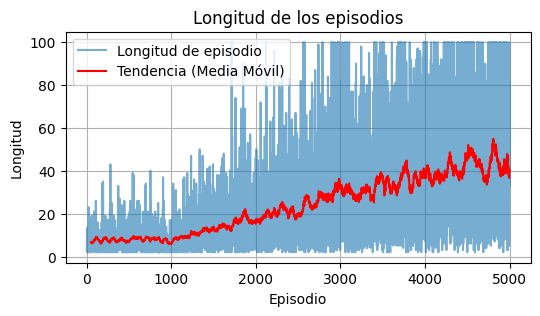

In [5]:
import numpy as np
import gymnasium as gym
import random
from src_agents import MonteCarloOffPolicy
import matplotlib.pyplot as plt

# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Establecer semilla en el entorno con el método reset
env.reset(seed=seed_value)

# Crear y entrenar el agente
agente = MonteCarloOffPolicy(env, decay=True)
Q, stats, episode_lengths = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final con MonteCarloOffPolicy:")
print(Q)

# Graficar las estadísticas y las longitudes de los episodios
plot(stats)
plot_episode_lengths(episode_lengths)


In [ ]:
import numpy as np
import gymnasium as gym
import random
from src_agents import SARSA
import matplotlib.pyplot as plt

# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Establecer semilla en el entorno con el método reset
env.reset(seed=seed_value)

# Crear y entrenar el agente
agente = SARSA(env, decay=True)
Q, stats, episode_lengths = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final con SARSA:")
print(Q)

# Graficar las estadísticas y las longitudes de los episodios
plot(stats)
plot_episode_lengths(episode_lengths)


Entrenando:  11%|████▌                                    | 549/5000 [00:01<00:10, 413.66episodio/s]

Episodio 500, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  21%|████████▍                               | 1053/5000 [00:02<00:09, 400.71episodio/s]

Episodio 1000, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  31%|████████████▍                           | 1560/5000 [00:03<00:08, 409.59episodio/s]

Episodio 1500, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  41%|████████████████▍                       | 2056/5000 [00:05<00:07, 393.56episodio/s]

Episodio 2000, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  51%|████████████████████▎                   | 2534/5000 [00:06<00:06, 401.98episodio/s]

Episodio 2500, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  62%|████████████████████████▊               | 3100/5000 [00:07<00:04, 441.61episodio/s]

Episodio 3000, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  72%|████████████████████████████▌           | 3576/5000 [00:08<00:03, 433.08episodio/s]

Episodio 3500, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  81%|████████████████████████████████▍       | 4050/5000 [00:09<00:02, 420.49episodio/s]

Episodio 4000, éxito promedio: 0.00, epsilon: 0.10


Entrenando:  91%|████████████████████████████████████▌   | 4566/5000 [00:11<00:01, 423.73episodio/s]

Episodio 4500, éxito promedio: 0.00, epsilon: 0.10


Entrenando: 100%|████████████████████████████████████████| 5000/5000 [00:12<00:00, 406.93episodio/s]


ValueError: too many values to unpack (expected 2)

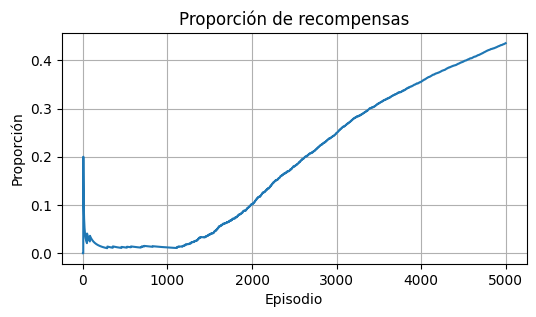

In [14]:
plot(stats)  # Proporción de recompensas


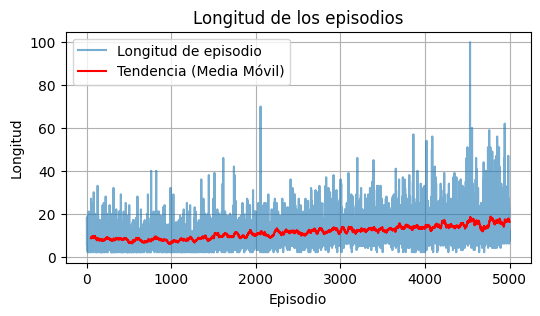

In [12]:
plot_episode_lengths(episode_lengths)  # Longitud de los episodios

In [8]:
import numpy as np
import gymnasium as gym
import random
from src_agents import SARSA

# Establecer semilla para reproducibilidad
seed_value = 42
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Establecer semilla en el entorno con el método reset
env.reset(seed=seed_value)

# Crear y entrenar el agente
agente = SARSA(env, decay=True)
Q, stats = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final con SARSA:")
print(Q)


Entrenando:  13%|█████▎                                  | 661/5000 [00:00<00:03, 1123.15episodio/s]

Episodio 500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  30%|███████████▋                           | 1502/5000 [00:00<00:01, 2247.69episodio/s]

Episodio 1000, éxito promedio: 0.21, epsilon: 0.40
Episodio 1500, éxito promedio: 0.31, epsilon: 0.40


Entrenando:  46%|██████████████████                     | 2309/5000 [00:01<00:01, 2413.31episodio/s]

Episodio 2000, éxito promedio: 0.36, epsilon: 0.40


Entrenando:  56%|█████████████████████▉                 | 2817/5000 [00:01<00:00, 2480.04episodio/s]

Episodio 2500, éxito promedio: 0.40, epsilon: 0.40
Episodio 3000, éxito promedio: 0.41, epsilon: 0.40


Entrenando:  77%|█████████████████████████████▉         | 3831/5000 [00:01<00:00, 2501.37episodio/s]

Episodio 3500, éxito promedio: 0.43, epsilon: 0.40
Episodio 4000, éxito promedio: 0.44, epsilon: 0.40


Entrenando:  97%|██████████████████████████████████████ | 4872/5000 [00:02<00:00, 2492.76episodio/s]

Episodio 4500, éxito promedio: 0.46, epsilon: 0.40


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:02<00:00, 2163.85episodio/s]


ValueError: too many values to unpack (expected 2)

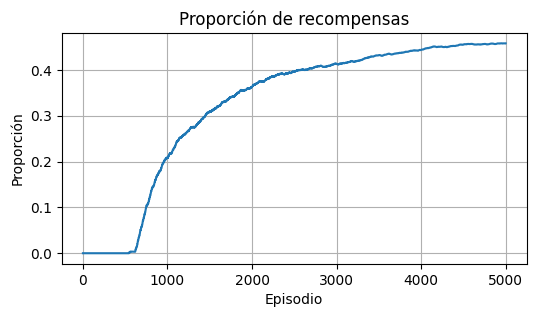

In [17]:
plot(stats)  # Proporción de recompensas

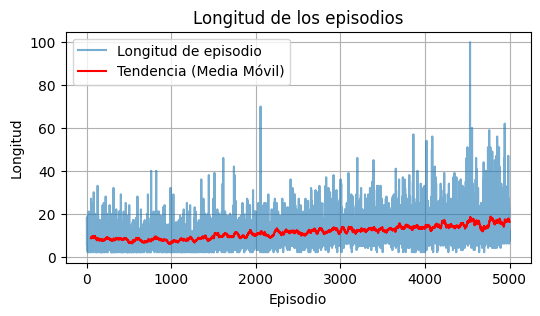

In [18]:
plot_episode_lengths(episode_lengths)  # Longitud de los episodios

In [ ]:
import numpy as np
import gymnasium as gym
import random
from src_agents import QLearning

# Establecer semilla para reproducibilidad
seed_value = 42
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Establecer semilla en el entorno con el método reset
env.reset(seed=seed_value)

# Crear y entrenar el agente
agente = QLearning(env, decay=True)
Q, stats = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final con QLearning:")
print(Q)

plot(stats)
plot_episode_lengths(episode_lengths) 


Entrenando:  13%|█████▎                                  | 668/5000 [00:00<00:04, 1052.05episodio/s]

Episodio 500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  30%|███████████▊                           | 1519/5000 [00:00<00:01, 2262.13episodio/s]

Episodio 1000, éxito promedio: 0.19, epsilon: 0.40
Episodio 1500, éxito promedio: 0.29, epsilon: 0.40


Entrenando:  48%|██████████████████▉                    | 2425/5000 [00:01<00:00, 2760.45episodio/s]

Episodio 2000, éxito promedio: 0.35, epsilon: 0.40
Episodio 2500, éxito promedio: 0.38, epsilon: 0.40


Entrenando:  66%|█████████████████████████▋             | 3286/5000 [00:01<00:00, 2810.56episodio/s]

Episodio 3000, éxito promedio: 0.40, epsilon: 0.40
Episodio 3500, éxito promedio: 0.42, epsilon: 0.40


Entrenando:  90%|██████████████████████████████████▉    | 4480/5000 [00:01<00:00, 2961.90episodio/s]

Episodio 4000, éxito promedio: 0.43, epsilon: 0.40
Episodio 4500, éxito promedio: 0.44, epsilon: 0.40


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:02<00:00, 2360.66episodio/s]

Valor Q final con QLearning:
[[1.         1.         1.         1.        ]
 [1.         0.         0.99996243 0.99991554]
 [0.99999995 0.80741173 0.35117322 0.90954937]
 [0.69171097 0.         0.06574566 0.05368011]
 [1.         1.         0.         1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.61257891 0.         0.99925202]
 [0.         0.         0.         0.        ]
 [1.         0.         1.         1.        ]
 [1.         1.         1.         0.        ]
 [1.         0.99985456 0.         0.99474174]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         1.         1.         1.        ]
 [1.         1.         1.         1.        ]
 [0.         0.         0.         0.        ]]


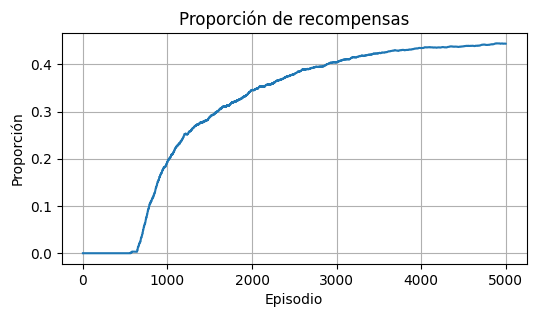

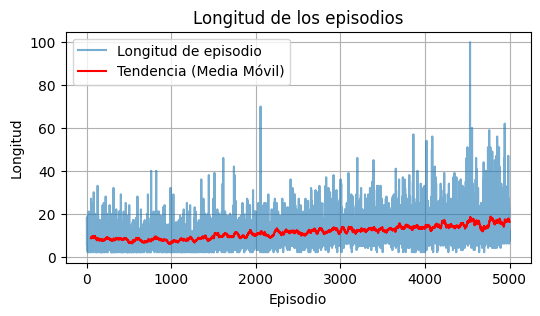

In [ ]:
  # Proporción de recompensas

----


In [47]:
import numpy as np
import gymnasium as gym
import random

# Establecer semilla para reproducibilidad
seed_value = 42
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Establecer semilla en el entorno con el método reset
env.reset(seed=seed_value)  # Pasar la semilla al método reset

# Crear y entrenar el agente
agente = MonteCarloOnPolicy(env, decay=True)
Q, stats = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final (primer entrenamiento):")
print(Q)


Entrenando:  19%|███████▍                                | 937/5000 [00:00<00:01, 3122.28episodio/s]

Episodio 500, éxito promedio: 0.01, epsilon: 1.00
Episodio 1000, éxito promedio: 0.01, epsilon: 1.00


Entrenando:  38%|██████████████▋                        | 1877/5000 [00:00<00:01, 2859.33episodio/s]

Episodio 1500, éxito promedio: 0.04, epsilon: 0.67


Entrenando:  49%|███████████████████                    | 2436/5000 [00:00<00:01, 2533.18episodio/s]

Episodio 2000, éxito promedio: 0.10, epsilon: 0.50
Episodio 2500, éxito promedio: 0.18, epsilon: 0.40


Entrenando:  63%|████████████████████████▋              | 3164/5000 [00:01<00:00, 2176.55episodio/s]

Episodio 3000, éxito promedio: 0.25, epsilon: 0.33


Entrenando:  76%|█████████████████████████████▋         | 3802/5000 [00:01<00:00, 1996.39episodio/s]

Episodio 3500, éxito promedio: 0.31, epsilon: 0.29


Entrenando:  84%|████████████████████████████████▋      | 4195/5000 [00:01<00:00, 1897.71episodio/s]

Episodio 4000, éxito promedio: 0.36, epsilon: 0.25


Entrenando:  95%|█████████████████████████████████████▏ | 4760/5000 [00:02<00:00, 1825.23episodio/s]

Episodio 4500, éxito promedio: 0.40, epsilon: 0.22


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:02<00:00, 2226.72episodio/s]

Valor Q final (primer entrenamiento):
[[0.60703445 0.39069915 0.38543004 0.36887061]
 [0.19158879 0.         0.52764045 0.20265781]
 [0.25531915 0.61068702 0.26237624 0.3373494 ]
 [0.39849624 0.         0.10852713 0.15533981]
 [0.20212766 0.55641142 0.         0.21383648]
 [0.         0.         0.         0.        ]
 [0.         0.82065597 0.         0.48031496]
 [0.         0.         0.         0.        ]
 [0.37175793 0.         0.68807339 0.38392857]
 [0.4529148  0.81868132 0.56331878 0.        ]
 [0.55248619 0.95120175 0.         0.5505618 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.64583333 0.95447761 0.57276995]
 [0.76277372 0.90688259 1.         0.75954198]
 [0.         0.         0.         0.        ]]


In [43]:
# Crear el entorno
env = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Crear y entrenar el agente
agente = MonteCarloOnPolicy(env, decay=True)
Q, stats = agente.entrenar()

# Mostrar el valor Q final
print("Valor Q final:")
print(Q)


Entrenando:  20%|███████▉                                | 986/5000 [00:00<00:01, 3270.50episodio/s]

Episodio 500, éxito promedio: 0.01, epsilon: 1.00
Episodio 1000, éxito promedio: 0.02, epsilon: 1.00


Entrenando:  41%|███████████████▊                       | 2027/5000 [00:00<00:00, 3402.68episodio/s]

Episodio 1500, éxito promedio: 0.05, epsilon: 0.67
Episodio 2000, éxito promedio: 0.12, epsilon: 0.50


Entrenando:  62%|████████████████████████               | 3079/5000 [00:00<00:00, 3443.20episodio/s]

Episodio 2500, éxito promedio: 0.20, epsilon: 0.40
Episodio 3000, éxito promedio: 0.25, epsilon: 0.33


Entrenando:  76%|█████████████████████████████▋         | 3814/5000 [00:01<00:00, 3546.26episodio/s]

Episodio 3500, éxito promedio: 0.31, epsilon: 0.29
Episodio 4000, éxito promedio: 0.37, epsilon: 0.25


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:01<00:00, 3463.19episodio/s]

Episodio 4500, éxito promedio: 0.41, epsilon: 0.22
Valor Q final:
[[0.17218543 0.46924969 0.15       0.17988008]
 [0.07481297 0.         0.25721785 0.06637168]
 [0.09649123 0.3633157  0.11637931 0.11004785]
 [0.2        0.         0.04166667 0.04123711]
 [0.27806789 0.6021419  0.         0.28315412]
 [0.         0.         0.         0.        ]
 [0.         0.6902834  0.         0.24615385]
 [0.         0.         0.         0.        ]
 [0.40778689 0.         0.72383721 0.3759542 ]
 [0.53693182 0.68983957 0.84076955 0.        ]
 [0.65982405 0.96259673 0.         0.55481728]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.57291667 0.90658174 0.36842105]
 [0.74725275 0.91208791 1.         0.79194631]
 [0.         0.         0.         0.        ]]


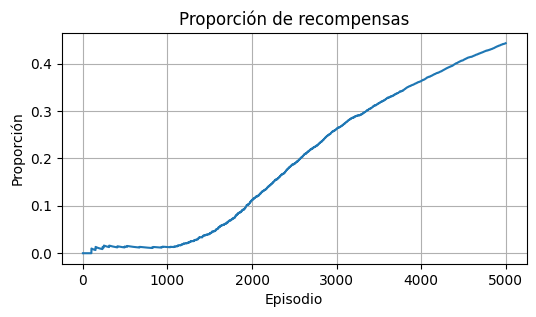

In [20]:
plot(list_stats=agente.list_stats)

In [21]:
# Obtener la mejor política aprendida
from src_agents import *
pi_optima, acciones = pi_star_from_Q(env, agente.Q)
print("Política óptima obtenida\n", pi_optima, f"\n Acciones {acciones} \n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida
 [[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 1, 1, 2, 1, 2, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




MonteCarloOffPolicy

In [23]:
# Crear el entorno
envMCOffPo = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Crear y entrenar el agente
agenteMCOffPo = MonteCarloOffPolicy(envMCOffPo, decay=True)
QMCOffPo, statsMCOffPo = agenteMCOffPo.entrenar()

# Mostrar el valor Q final
print("Valor Q final:")
print(QMCOffPo)

Entrenando:  19%|███████▌                                | 946/5000 [00:00<00:01, 3163.75episodio/s]

Episodio 500, éxito promedio: 0.02, epsilon: 1.00
Episodio 1000, éxito promedio: 0.02, epsilon: 1.00


Entrenando:  39%|███████████████▏                       | 1941/5000 [00:00<00:00, 3206.96episodio/s]

Episodio 1500, éxito promedio: 0.04, epsilon: 0.67
Episodio 2000, éxito promedio: 0.12, epsilon: 0.50


Entrenando:  60%|███████████████████████▍               | 3003/5000 [00:00<00:00, 3435.39episodio/s]

Episodio 2500, éxito promedio: 0.19, epsilon: 0.40
Episodio 3000, éxito promedio: 0.25, epsilon: 0.33


Entrenando:  82%|████████████████████████████████       | 4104/5000 [00:01<00:00, 3609.89episodio/s]

Episodio 3500, éxito promedio: 0.31, epsilon: 0.29
Episodio 4000, éxito promedio: 0.35, epsilon: 0.25


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:01<00:00, 3389.02episodio/s]

Episodio 4500, éxito promedio: 0.40, epsilon: 0.22
Valor Q final:
[[0.15744401 0.45568562 0.16831683 0.1677763 ]
 [0.06289308 0.         0.31288344 0.07068607]
 [0.11673152 0.45724258 0.13709677 0.19607843]
 [0.24637681 0.         0.01834862 0.06481481]
 [0.2465582  0.58589462 0.         0.26642336]
 [0.         0.         0.         0.        ]
 [0.         0.7807377  0.         0.296     ]
 [0.         0.         0.         0.        ]
 [0.43050193 0.         0.72426595 0.33655706]
 [0.55389222 0.73333333 0.82571912 0.        ]
 [0.6350365  0.95954266 0.         0.58208955]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.63333333 0.92214112 0.53333333]
 [0.77470356 0.90252708 1.         0.72764228]
 [0.         0.         0.         0.        ]]


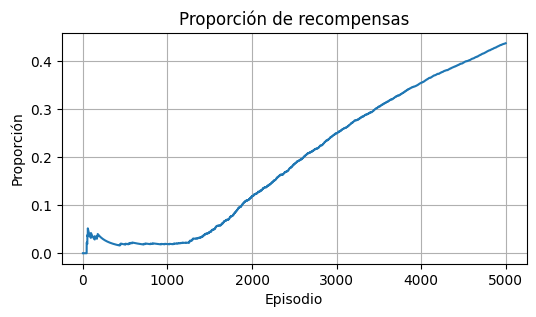

In [24]:
plot(list_stats=agenteMCOffPo.list_stats)

In [ ]:
plot_episode_lengths(episode_lengths=agenteMCOffPo.episode_lengths)

Sarsa

In [30]:
# Crear el entorno
envSarsa = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Crear y entrenar el agente
agenteSarsa = SARSA(envSarsa, decay=True)
QSarsa, statsSarsa = agenteSarsa.entrenar()

# Mostrar el valor Q final
print("Valor Q final:")
print(QSarsa)

Entrenando:  14%|█████▋                                  | 711/5000 [00:00<00:03, 1201.47episodio/s]

Episodio 500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  24%|█████████▍                             | 1206/5000 [00:01<00:03, 1187.16episodio/s]

Episodio 1000, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  32%|████████████▍                          | 1587/5000 [00:01<00:02, 1226.90episodio/s]

Episodio 1500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  44%|█████████████████▏                     | 2196/5000 [00:01<00:02, 1182.61episodio/s]

Episodio 2000, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  54%|████████████████████▉                  | 2679/5000 [00:02<00:01, 1185.88episodio/s]

Episodio 2500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  64%|████████████████████████▊              | 3175/5000 [00:02<00:01, 1189.69episodio/s]

Episodio 3000, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  75%|█████████████████████████████▍         | 3767/5000 [00:03<00:00, 1508.82episodio/s]

Episodio 3500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  87%|██████████████████████████████████     | 4360/5000 [00:03<00:00, 2233.99episodio/s]

Episodio 4000, éxito promedio: 0.06, epsilon: 0.40
Episodio 4500, éxito promedio: 0.11, epsilon: 0.40


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:03<00:00, 1420.41episodio/s]

Valor Q final:
[[0.47129321 0.53044557 0.39556066 0.4699808 ]
 [0.48503836 0.         0.42920743 0.39039974]
 [0.07711396 0.61490822 0.01219949 0.06019359]
 [0.09716987 0.         0.         0.        ]
 [0.49129828 0.54674598 0.         0.51001189]
 [0.         0.         0.         0.        ]
 [0.         0.78616664 0.         0.15924468]
 [0.         0.         0.         0.        ]
 [0.56537941 0.         0.70420371 0.52826104]
 [0.64204128 0.71893488 0.67302919 0.        ]
 [0.71924861 0.95790049 0.         0.4656763 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.7577232  0.97914778 0.73313382]
 [0.81965661 0.99199519 1.         0.80158242]
 [0.         0.         0.         0.        ]]


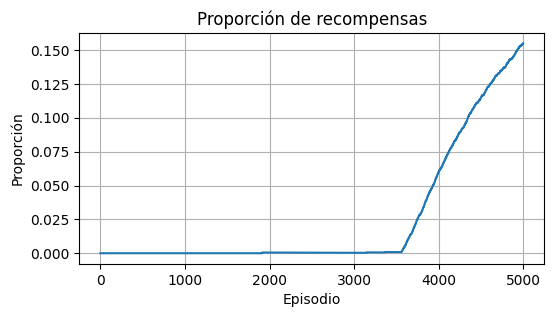

In [31]:
plot(list_stats=agenteSarsa.list_stats)

In [ ]:
plot_episode_lengths(episode_lengths=agenteSarsa.episode_lengths)

Q-Learning

In [40]:
# Crear el entorno
envQlearning = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Crear y entrenar el agente
agenteQL = SARSA(envQlearning, decay=False)
QQL, statsQL = agenteQL.entrenar()

# Mostrar el valor Q final
print("Valor Q final:")
print(QQL)

Entrenando:  15%|█████▊                                  | 729/5000 [00:00<00:03, 1201.79episodio/s]

Episodio 500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  22%|████████▋                              | 1116/5000 [00:00<00:03, 1212.30episodio/s]

Episodio 1000, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  35%|█████████████▋                         | 1754/5000 [00:01<00:02, 1268.00episodio/s]

Episodio 1500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  42%|████████████████▌                      | 2122/5000 [00:01<00:02, 1166.27episodio/s]

Episodio 2000, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  52%|████████████████████▍                  | 2614/5000 [00:02<00:01, 1209.01episodio/s]

Episodio 2500, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  64%|█████████████████████████              | 3216/5000 [00:02<00:01, 1188.23episodio/s]

Episodio 3000, éxito promedio: 0.00, epsilon: 0.40


Entrenando:  80%|███████████████████████████████▎       | 4014/5000 [00:03<00:00, 2032.91episodio/s]

Episodio 3500, éxito promedio: 0.00, epsilon: 0.40
Episodio 4000, éxito promedio: 0.06, epsilon: 0.40


Entrenando: 100%|███████████████████████████████████████| 5000/5000 [00:03<00:00, 1434.26episodio/s]

Episodio 4500, éxito promedio: 0.11, epsilon: 0.40
Valor Q final:
[[0.46007372 0.52478003 0.3921225  0.46369776]
 [0.46771385 0.         0.24664425 0.39887153]
 [0.38434015 0.20038833 0.02809853 0.15059441]
 [0.10258694 0.         0.         0.        ]
 [0.47488477 0.62544822 0.         0.48965351]
 [0.         0.         0.         0.        ]
 [0.         0.65386996 0.         0.0706461 ]
 [0.         0.         0.         0.        ]
 [0.52993694 0.         0.65756039 0.49071742]
 [0.54727458 0.61379884 0.83867386 0.        ]
 [0.69254515 0.95536994 0.         0.44848599]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.86549455 0.94620876 0.53816326]
 [0.66152423 0.92462337 1.         0.694666  ]
 [0.         0.         0.         0.        ]]


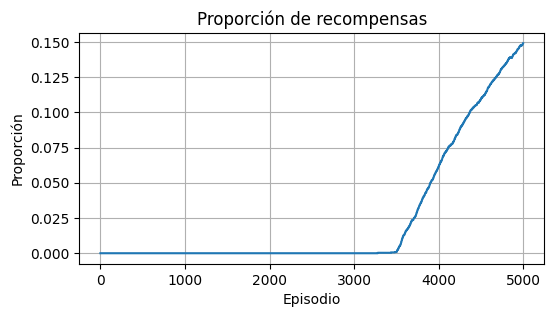

In [41]:
plot(list_stats=agenteQL.list_stats)

In [ ]:
plot_episode_lengths(episode_lengths=agenteQlearning.episode_lengths)